In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from os import cpu_count

In [66]:
import matplotlib as plt
import matplotlib.style as stl
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [89]:
plt.rcParams['figure.figsize'] = 16, 10

In [87]:
import pylab

In [2]:
pd.options.display.max_columns = None
n_jobs = max(cpu_count()-1, 1)

In [3]:
train_df = pd.read_csv('train.csv',sep='\t').drop('Unnamed: 0',axis=1)
test_df = pd.read_csv('test.csv',sep='\t').drop('Unnamed: 0',axis=1)

# Preprocessing

In [4]:
#9 is highly correlated with 2
correlated = ['9']
constant_values = ['5', '11', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305','152', '160','140', '164']

#too_much_zeros_features = ['191', '182', '185', '181', '172', '170', '157', '136', '135']

In [5]:
train_df = train_df.drop(correlated,axis=1)
train_df = train_df.drop(constant_values,axis=1)
test_df = test_df.drop(correlated,axis=1)
test_df = test_df.drop(constant_values,axis=1)

# Base model

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
X = train_df.drop(['0'], axis=1)
y = train_df['0']

In [8]:
parameters={
   'objective': 'binary',
    'learning_rate': 0.01,
    'max_depth': 8,
    'num_threads': 4,
    'metric': 'auc',
    'seed': 42,
    'colsample_bytree': 0.65,
    'subsample': 0.8,
    'subsample_freq': 2,
    'min_data_in_leaf': 15,
}
n_rounds = 10000

In [9]:
lgb_train = lgb.Dataset(X, label=y, free_raw_data=False)

In [10]:
result_base = lgb.cv(parameters, lgb_train, n_rounds, folds=skf.split(X, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.678943 + 0.00414656
[2]	cv_agg's auc: 0.691799 + 0.00885539
[3]	cv_agg's auc: 0.699423 + 0.00930007
[4]	cv_agg's auc: 0.705288 + 0.00752174
[5]	cv_agg's auc: 0.706464 + 0.00864524
[6]	cv_agg's auc: 0.70811 + 0.00701798
[7]	cv_agg's auc: 0.708472 + 0.00756751
[8]	cv_agg's auc: 0.709882 + 0.00786181
[9]	cv_agg's auc: 0.710649 + 0.00688371
[10]	cv_agg's auc: 0.710904 + 0.00661881
[11]	cv_agg's auc: 0.710834 + 0.00638842
[12]	cv_agg's auc: 0.710676 + 0.00615256
[13]	cv_agg's auc: 0.710921 + 0.00597416
[14]	cv_agg's auc: 0.710913 + 0.00600064
[15]	cv_agg's auc: 0.71076 + 0.00636688
[16]	cv_agg's auc: 0.710813 + 0.00675971
[17]	cv_agg's auc: 0.710831 + 0.00641083
[18]	cv_agg's auc: 0.711278 + 0.00649868
[19]	cv_agg's auc: 0.711492 + 0.00622084
[20]	cv_agg's auc: 0.711621 + 0.00583808
[21]	cv_agg's auc: 0.711569 + 0.00573416
[22]	cv_agg's auc: 0.712189 + 0.0056832
[23]	cv_agg's auc: 0.712196 + 0.00565143
[24]	cv_agg's auc: 0.71195 + 0.00554054
[25]	cv_agg's auc: 0.712087 +

[200]	cv_agg's auc: 0.729914 + 0.00528729
[201]	cv_agg's auc: 0.729959 + 0.0052274
[202]	cv_agg's auc: 0.729994 + 0.0052377
[203]	cv_agg's auc: 0.730061 + 0.0051952
[204]	cv_agg's auc: 0.730121 + 0.00517114
[205]	cv_agg's auc: 0.730207 + 0.00513997
[206]	cv_agg's auc: 0.73029 + 0.005194
[207]	cv_agg's auc: 0.730317 + 0.00516323
[208]	cv_agg's auc: 0.730384 + 0.0050836
[209]	cv_agg's auc: 0.730397 + 0.00512006
[210]	cv_agg's auc: 0.730447 + 0.00511987
[211]	cv_agg's auc: 0.730537 + 0.0051367
[212]	cv_agg's auc: 0.730671 + 0.00513893
[213]	cv_agg's auc: 0.730777 + 0.00511802
[214]	cv_agg's auc: 0.730925 + 0.0050895
[215]	cv_agg's auc: 0.73104 + 0.00511107
[216]	cv_agg's auc: 0.731168 + 0.00514245
[217]	cv_agg's auc: 0.731291 + 0.0051576
[218]	cv_agg's auc: 0.731437 + 0.00514138
[219]	cv_agg's auc: 0.731521 + 0.00514935
[220]	cv_agg's auc: 0.731596 + 0.00511187
[221]	cv_agg's auc: 0.73168 + 0.00516059
[222]	cv_agg's auc: 0.731796 + 0.00520714
[223]	cv_agg's auc: 0.731865 + 0.00526018
[224

[400]	cv_agg's auc: 0.74019 + 0.00601696
[401]	cv_agg's auc: 0.740196 + 0.00599507
[402]	cv_agg's auc: 0.74021 + 0.00598366
[403]	cv_agg's auc: 0.740222 + 0.00599678
[404]	cv_agg's auc: 0.740221 + 0.00606588
[405]	cv_agg's auc: 0.740264 + 0.00606578
[406]	cv_agg's auc: 0.740302 + 0.00607427
[407]	cv_agg's auc: 0.740327 + 0.00608929
[408]	cv_agg's auc: 0.740331 + 0.00607602
[409]	cv_agg's auc: 0.740353 + 0.00604269
[410]	cv_agg's auc: 0.740372 + 0.00604482
[411]	cv_agg's auc: 0.740377 + 0.00603633
[412]	cv_agg's auc: 0.740416 + 0.00602365
[413]	cv_agg's auc: 0.740422 + 0.00603471
[414]	cv_agg's auc: 0.74047 + 0.00601619
[415]	cv_agg's auc: 0.740499 + 0.0059924
[416]	cv_agg's auc: 0.740531 + 0.0060083
[417]	cv_agg's auc: 0.740559 + 0.00599365
[418]	cv_agg's auc: 0.740604 + 0.00599028
[419]	cv_agg's auc: 0.740613 + 0.00599272
[420]	cv_agg's auc: 0.74059 + 0.00596812
[421]	cv_agg's auc: 0.740624 + 0.00593429
[422]	cv_agg's auc: 0.740642 + 0.00592547
[423]	cv_agg's auc: 0.740667 + 0.0059069

[597]	cv_agg's auc: 0.744352 + 0.00577757
[598]	cv_agg's auc: 0.744378 + 0.00578039
[599]	cv_agg's auc: 0.744367 + 0.00575947
[600]	cv_agg's auc: 0.744412 + 0.00571082
[601]	cv_agg's auc: 0.744455 + 0.0057506
[602]	cv_agg's auc: 0.744474 + 0.0057172
[603]	cv_agg's auc: 0.74449 + 0.00573312
[604]	cv_agg's auc: 0.744509 + 0.00575296
[605]	cv_agg's auc: 0.744506 + 0.00578911
[606]	cv_agg's auc: 0.744552 + 0.00577781
[607]	cv_agg's auc: 0.744562 + 0.00578086
[608]	cv_agg's auc: 0.744564 + 0.00579106
[609]	cv_agg's auc: 0.744554 + 0.00580131
[610]	cv_agg's auc: 0.744577 + 0.00579368
[611]	cv_agg's auc: 0.744604 + 0.00583317
[612]	cv_agg's auc: 0.744631 + 0.00583064
[613]	cv_agg's auc: 0.744634 + 0.00582463
[614]	cv_agg's auc: 0.744635 + 0.00580601
[615]	cv_agg's auc: 0.744635 + 0.00580066
[616]	cv_agg's auc: 0.744668 + 0.00581085
[617]	cv_agg's auc: 0.744653 + 0.00578686
[618]	cv_agg's auc: 0.744637 + 0.00578878
[619]	cv_agg's auc: 0.744643 + 0.00579214
[620]	cv_agg's auc: 0.744687 + 0.0058

In [11]:
max(result_base['auc-mean']), len(result_base['auc-mean']) 

(0.7454628573901237, 716)

# Dimensionality Reduction

### PCA

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=250)

In [14]:
#pca.fit(X)

In [15]:
X_transform_pca = pca.fit_transform(X)

In [16]:
X.shape

(30500, 322)

In [17]:
X_transform_pca.shape

(30500, 250)

In [18]:
lgb_train_pca = lgb.Dataset(X_transform_pca, label=y, free_raw_data=False)

In [19]:
result_pca = lgb.cv(parameters, lgb_train_pca, n_rounds, folds=skf.split(X_transform_pca, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.619281 + 0.012692
[2]	cv_agg's auc: 0.663023 + 0.00821402
[3]	cv_agg's auc: 0.679521 + 0.00681948
[4]	cv_agg's auc: 0.687951 + 0.00766815
[5]	cv_agg's auc: 0.689274 + 0.00757241
[6]	cv_agg's auc: 0.692374 + 0.00877216
[7]	cv_agg's auc: 0.693639 + 0.00675645
[8]	cv_agg's auc: 0.695587 + 0.00642009
[9]	cv_agg's auc: 0.697503 + 0.0079983
[10]	cv_agg's auc: 0.698697 + 0.00746936
[11]	cv_agg's auc: 0.699519 + 0.00757893
[12]	cv_agg's auc: 0.70021 + 0.00740058
[13]	cv_agg's auc: 0.701043 + 0.0069817
[14]	cv_agg's auc: 0.70153 + 0.00727956
[15]	cv_agg's auc: 0.701785 + 0.00713832
[16]	cv_agg's auc: 0.701751 + 0.00705419
[17]	cv_agg's auc: 0.702382 + 0.00694194
[18]	cv_agg's auc: 0.702506 + 0.00673658
[19]	cv_agg's auc: 0.702929 + 0.00693884
[20]	cv_agg's auc: 0.703653 + 0.00762274
[21]	cv_agg's auc: 0.703592 + 0.00785723
[22]	cv_agg's auc: 0.703812 + 0.0077256
[23]	cv_agg's auc: 0.703868 + 0.00777244
[24]	cv_agg's auc: 0.704618 + 0.00790457
[25]	cv_agg's auc: 0.704933 + 0.

[201]	cv_agg's auc: 0.719562 + 0.00744468
[202]	cv_agg's auc: 0.719634 + 0.00749779
[203]	cv_agg's auc: 0.719691 + 0.00747664
[204]	cv_agg's auc: 0.719733 + 0.00749264
[205]	cv_agg's auc: 0.719779 + 0.00749532
[206]	cv_agg's auc: 0.719843 + 0.00743792
[207]	cv_agg's auc: 0.719894 + 0.00749146
[208]	cv_agg's auc: 0.719927 + 0.00747793
[209]	cv_agg's auc: 0.720047 + 0.00748312
[210]	cv_agg's auc: 0.720038 + 0.00747187
[211]	cv_agg's auc: 0.720138 + 0.00747617
[212]	cv_agg's auc: 0.720218 + 0.00744895
[213]	cv_agg's auc: 0.72025 + 0.00739369
[214]	cv_agg's auc: 0.720302 + 0.0073171
[215]	cv_agg's auc: 0.720389 + 0.00736458
[216]	cv_agg's auc: 0.720465 + 0.00733199
[217]	cv_agg's auc: 0.720584 + 0.00732354
[218]	cv_agg's auc: 0.720582 + 0.00733115
[219]	cv_agg's auc: 0.720824 + 0.00730979
[220]	cv_agg's auc: 0.720928 + 0.00735574
[221]	cv_agg's auc: 0.721016 + 0.00724668
[222]	cv_agg's auc: 0.721071 + 0.00725957
[223]	cv_agg's auc: 0.721095 + 0.00715798
[224]	cv_agg's auc: 0.721138 + 0.007

[397]	cv_agg's auc: 0.728853 + 0.00695111
[398]	cv_agg's auc: 0.728897 + 0.00694954
[399]	cv_agg's auc: 0.728956 + 0.00694382
[400]	cv_agg's auc: 0.728973 + 0.00696918
[401]	cv_agg's auc: 0.72897 + 0.00695077
[402]	cv_agg's auc: 0.72899 + 0.00690574
[403]	cv_agg's auc: 0.729057 + 0.00688665
[404]	cv_agg's auc: 0.7291 + 0.00691015
[405]	cv_agg's auc: 0.729187 + 0.0069059
[406]	cv_agg's auc: 0.729213 + 0.00695266
[407]	cv_agg's auc: 0.729214 + 0.00698511
[408]	cv_agg's auc: 0.729256 + 0.00697352
[409]	cv_agg's auc: 0.729303 + 0.00699252
[410]	cv_agg's auc: 0.72937 + 0.00693505
[411]	cv_agg's auc: 0.729397 + 0.00694481
[412]	cv_agg's auc: 0.729405 + 0.006996
[413]	cv_agg's auc: 0.729403 + 0.00697487
[414]	cv_agg's auc: 0.729458 + 0.00700924
[415]	cv_agg's auc: 0.729487 + 0.00704418
[416]	cv_agg's auc: 0.729548 + 0.00704111
[417]	cv_agg's auc: 0.729566 + 0.00705562
[418]	cv_agg's auc: 0.729597 + 0.00706932
[419]	cv_agg's auc: 0.729639 + 0.00707989
[420]	cv_agg's auc: 0.729631 + 0.00712004


[594]	cv_agg's auc: 0.732725 + 0.00736994
[595]	cv_agg's auc: 0.73274 + 0.00738379
[596]	cv_agg's auc: 0.732766 + 0.00740648
[597]	cv_agg's auc: 0.732764 + 0.0074163
[598]	cv_agg's auc: 0.732788 + 0.00741858
[599]	cv_agg's auc: 0.732814 + 0.00742149
[600]	cv_agg's auc: 0.732865 + 0.00742441
[601]	cv_agg's auc: 0.732855 + 0.00743166
[602]	cv_agg's auc: 0.732865 + 0.00740982
[603]	cv_agg's auc: 0.732888 + 0.00744146
[604]	cv_agg's auc: 0.7329 + 0.00745626
[605]	cv_agg's auc: 0.732938 + 0.00749213
[606]	cv_agg's auc: 0.732933 + 0.00749601
[607]	cv_agg's auc: 0.732975 + 0.00748045
[608]	cv_agg's auc: 0.73301 + 0.00747889
[609]	cv_agg's auc: 0.733023 + 0.00747931
[610]	cv_agg's auc: 0.733022 + 0.00748411
[611]	cv_agg's auc: 0.733005 + 0.00755405
[612]	cv_agg's auc: 0.733008 + 0.00757363
[613]	cv_agg's auc: 0.732988 + 0.00759373
[614]	cv_agg's auc: 0.733006 + 0.00760962
[615]	cv_agg's auc: 0.732966 + 0.00760818
[616]	cv_agg's auc: 0.73302 + 0.0075834
[617]	cv_agg's auc: 0.73303 + 0.00762432


In [20]:
max(result_pca['auc-mean']), len(result_pca['auc-mean'])

(0.7330900637623274, 629)

### FastICA

In [21]:
from sklearn.decomposition import FastICA

In [22]:
ica = FastICA(n_components=250)

In [23]:
ica.fit(X)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=250, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [24]:
X_transform_ica = ica.transform(X)

In [25]:
X.shape

(30500, 322)

In [26]:
X_transform_ica.shape

(30500, 250)

In [27]:
lgb_train_ica = lgb.Dataset(X_transform_ica, label=y, free_raw_data=False)

In [28]:
result_ica = lgb.cv(parameters, lgb_train_ica, n_rounds, folds=skf.split(X_transform_ica, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.641763 + 0.00582075
[2]	cv_agg's auc: 0.663552 + 0.00221736
[3]	cv_agg's auc: 0.67912 + 0.00438526
[4]	cv_agg's auc: 0.683556 + 0.00279912
[5]	cv_agg's auc: 0.686203 + 0.00390788
[6]	cv_agg's auc: 0.687597 + 0.00377034
[7]	cv_agg's auc: 0.68959 + 0.00427127
[8]	cv_agg's auc: 0.689828 + 0.00462037
[9]	cv_agg's auc: 0.691993 + 0.00499982
[10]	cv_agg's auc: 0.692098 + 0.00441045
[11]	cv_agg's auc: 0.692805 + 0.004422
[12]	cv_agg's auc: 0.692625 + 0.00483176
[13]	cv_agg's auc: 0.694352 + 0.00484633
[14]	cv_agg's auc: 0.695015 + 0.00503631
[15]	cv_agg's auc: 0.695175 + 0.00535774
[16]	cv_agg's auc: 0.696247 + 0.00490025
[17]	cv_agg's auc: 0.69711 + 0.00524189
[18]	cv_agg's auc: 0.698352 + 0.00504853
[19]	cv_agg's auc: 0.698509 + 0.00495302
[20]	cv_agg's auc: 0.698542 + 0.00460973
[21]	cv_agg's auc: 0.698721 + 0.00419337
[22]	cv_agg's auc: 0.69888 + 0.00440662
[23]	cv_agg's auc: 0.698764 + 0.00429516
[24]	cv_agg's auc: 0.699515 + 0.00352162
[25]	cv_agg's auc: 0.699353 + 0

[200]	cv_agg's auc: 0.719902 + 0.00590393
[201]	cv_agg's auc: 0.719894 + 0.00590901
[202]	cv_agg's auc: 0.71991 + 0.00591449
[203]	cv_agg's auc: 0.720008 + 0.00599139
[204]	cv_agg's auc: 0.720109 + 0.00598188
[205]	cv_agg's auc: 0.720203 + 0.00604552
[206]	cv_agg's auc: 0.72024 + 0.0060713
[207]	cv_agg's auc: 0.720333 + 0.00620651
[208]	cv_agg's auc: 0.720416 + 0.00626644
[209]	cv_agg's auc: 0.720433 + 0.006304
[210]	cv_agg's auc: 0.720538 + 0.0062727
[211]	cv_agg's auc: 0.720602 + 0.00632554
[212]	cv_agg's auc: 0.720711 + 0.00636285
[213]	cv_agg's auc: 0.720847 + 0.00641354
[214]	cv_agg's auc: 0.720875 + 0.006458
[215]	cv_agg's auc: 0.720942 + 0.00645367
[216]	cv_agg's auc: 0.721031 + 0.00650213
[217]	cv_agg's auc: 0.721233 + 0.00646229
[218]	cv_agg's auc: 0.721389 + 0.00641819
[219]	cv_agg's auc: 0.721453 + 0.00640826
[220]	cv_agg's auc: 0.721534 + 0.00637252
[221]	cv_agg's auc: 0.721588 + 0.00642368
[222]	cv_agg's auc: 0.721683 + 0.00647672
[223]	cv_agg's auc: 0.721838 + 0.00651244


[398]	cv_agg's auc: 0.731203 + 0.00764957
[399]	cv_agg's auc: 0.731268 + 0.00766455
[400]	cv_agg's auc: 0.731271 + 0.00762857
[401]	cv_agg's auc: 0.731254 + 0.00757671
[402]	cv_agg's auc: 0.731298 + 0.00755219
[403]	cv_agg's auc: 0.731375 + 0.00752097
[404]	cv_agg's auc: 0.731398 + 0.00749938
[405]	cv_agg's auc: 0.731411 + 0.00747034
[406]	cv_agg's auc: 0.731453 + 0.00745163
[407]	cv_agg's auc: 0.731519 + 0.00750134
[408]	cv_agg's auc: 0.731558 + 0.00751138
[409]	cv_agg's auc: 0.731551 + 0.00756133
[410]	cv_agg's auc: 0.731555 + 0.00754848
[411]	cv_agg's auc: 0.731629 + 0.00752361
[412]	cv_agg's auc: 0.731705 + 0.00761136
[413]	cv_agg's auc: 0.731749 + 0.00762773
[414]	cv_agg's auc: 0.731779 + 0.0076228
[415]	cv_agg's auc: 0.731819 + 0.00758023
[416]	cv_agg's auc: 0.731777 + 0.00755768
[417]	cv_agg's auc: 0.731835 + 0.00753508
[418]	cv_agg's auc: 0.731884 + 0.00749709
[419]	cv_agg's auc: 0.731877 + 0.00746198
[420]	cv_agg's auc: 0.73192 + 0.00747206
[421]	cv_agg's auc: 0.731959 + 0.007

In [34]:
max(result_ica['auc-mean']), len(result_ica['auc-mean'])

(0.7331995690307264, 502)

### t-SNE


In [30]:
from sklearn.manifold import TSNE

In [91]:
tsne = TSNE(n_components=2)

In [ ]:
X_transform_tsne = tsne.fit_transform(X)

In [ ]:
lgb_train_tsne = lgb.Dataset(X_transform_tsne, label=y, free_raw_data=False)

In [ ]:
result = lgb.cv(parameters, lgb_train_tsne, n_rounds, folds=skf.split(X_transform_tsne, y), early_stopping_rounds=10, verbose_eval=1, )

In [ ]:
max(result['auc-mean']), len(result['auc-mean'])

# Sorry bro. Too long. may be next time  


### umap

In [35]:
import umap

In [32]:
X_transform_umap = umap.UMAP(n_neighbors=22,
                 min_dist=0.01,
                 metric='correlation').fit_transform(X)


In [36]:
lgb_train_umap = lgb.Dataset(X_transform_umap, label=y, free_raw_data=False)

In [37]:
result = lgb.cv(parameters, lgb_train_umap, n_rounds, folds=skf.split(X_transform_umap, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.640654 + 0.00896751
[2]	cv_agg's auc: 0.658887 + 0.00688516
[3]	cv_agg's auc: 0.657677 + 0.00719954
[4]	cv_agg's auc: 0.659772 + 0.00727475
[5]	cv_agg's auc: 0.65974 + 0.00777636
[6]	cv_agg's auc: 0.660195 + 0.00722512
[7]	cv_agg's auc: 0.66016 + 0.00779943
[8]	cv_agg's auc: 0.660375 + 0.00744137
[9]	cv_agg's auc: 0.660066 + 0.00766948
[10]	cv_agg's auc: 0.660492 + 0.007533
[11]	cv_agg's auc: 0.660251 + 0.00772417
[12]	cv_agg's auc: 0.660407 + 0.00740823
[13]	cv_agg's auc: 0.660436 + 0.00766601
[14]	cv_agg's auc: 0.660428 + 0.00748977
[15]	cv_agg's auc: 0.660381 + 0.00762957
[16]	cv_agg's auc: 0.660466 + 0.00742001
[17]	cv_agg's auc: 0.660445 + 0.00764562
[18]	cv_agg's auc: 0.66057 + 0.00752231
[19]	cv_agg's auc: 0.660524 + 0.00761318
[20]	cv_agg's auc: 0.660578 + 0.00750638
[21]	cv_agg's auc: 0.660433 + 0.00760672
[22]	cv_agg's auc: 0.660405 + 0.00741161
[23]	cv_agg's auc: 0.660416 + 0.00732713
[24]	cv_agg's auc: 0.660471 + 0.00727358
[25]	cv_agg's auc: 0.660486 + 

# Clastering

In [52]:
from sklearn.cluster import DBSCAN, KMeans

In [53]:
X_test = test_df.drop(['0'], axis=1)

In [54]:
X_with_target = X.copy() 
X_with_target['target'] = y
new_df = pd.concat([X_with_target, X_test], axis=0)
# add column for filtering train/test
new_df['is_train'] = True
new_df.loc[df['target'].isnull(), 'is_train'] = False

In [55]:
new_df.head()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train
0,1,1,0.352568,0.089094,0.011460,0.823985,0.063204,0.062223,0.35,0.173913,0.555556,0.075643,0.519230,0.293616,0.853005,0.315582,0.100401,0.837033,0.308740,0.75,0.969052,0.997754,1,0.064516,0.038252,0.820386,0.000000,0.50,0.000020,0.197605,0.021505,0,0.461538,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.028976,0.804959,0.256315,0.233609,0.207241,0.543609,0,0,0.636277,0.674055,0.411088,0.681005,0.492990,0.676865,0.510106,0.273482,0.666876,0.271396,0,0.743387,1.000000,1.0,0.761512,0.137851,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.130447,0.660812,0.150456,0.583333,0.341582,0,0.093772,1,0.332109,0,0.419192,0.062752,0.662008,0.181560,0.347370,0.004595,0.366032,0.813739,0.216998,0.783002,0,0.263109,0.909438,1,0.297790,0.797473,0.178935,0.221395,0,1,0,1,0,0.222222,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0.0,0.00000,0.0,0.0,0.090909,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0000,0.00000,0.0,0.0,0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.80904,0.00000,0.13484,0.40452,0.00000,0.40452,0.153846,0.020900,0.410139,1,1,1,0.936569,0.322213,1.0,True
1,1,1,0.352568,0.102546,0.036168,0.823985,0.072747,0.171335,0.25,0.217391,0.722222,0.103864,0.593750,0.073648,0.612603,0.222222,0.025549,0.737636,0.347640,1.00,0.341784,0.919910,1,0.064516,0.016164,0.773003,0.066100,0.50,0.067294,0.797904,0.053763,0,0.187500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.008943,0.740496,0.374360,0.171766,0.222209,0.707014,0,0,0.626137,0.644117,0.469494,0.668941,0.541728,0.716629,0.546316,0.482135,0.673065,0.381908,0,0.628642,1.000000,1.0,0.761512,0.107644,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.084065,0.588824,0.065451,0.488932,0.448880,0,0.093083,1,0.189719,0,0.310606,0.017096,0.504464,0.103531,0.256125,0.012358,0.480100,0.760360,0.280813,0.719187,0,0.252015,0.906516,0,0.207799,0.737641,0.110012,0.241508,0,1,0,0,0,0.111111,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0.0,0.00000,0.0,0.0,0.090909,0.0,0.46291,0.00000,0.15430,0.0,0.0,0.1543,0.00000,0.0,0.0,0,0.0,0.0,0.46291,0.46291,0.30861,0.0,0.46291,0.00000,0.00000,0.00000,0.00000,0.00000,0.269231,0.025723,0.440312,1,1,1,0.558273,0.322213,1.0,True
2,1,1,0.146644,0.000756,0.000024,1.000000,0.001289,0.015625,0.20,0.086957,0.611111,0.083598,0.575000,0.110840,0.690868,0.252991,0.041802,0.796249,0.395747,0.75,0.339980,0.919162,1,

# k_means and pca

In [56]:
pca_k_means = PCA(n_components=2)

In [57]:
new_df.columns[:-2]

Index(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=322)

In [58]:
df_pca = pca_k_means.fit_transform(new_df[new_df.columns[:-2]])

In [59]:
km = KMeans(n_clusters=4, n_jobs=n_jobs)

In [60]:
clustered_labels_km = km.fit_predict(df_pca)

In [61]:
clustered_labels_km

array([0, 0, 0, ..., 1, 1, 2])

In [63]:
np.unique(clustered_labels_km)

array([0, 1, 2, 3])

In [64]:
np.unique(clustered_labels_km).shape[0]

4

In [65]:
pd.Series(clustered_labels_km).value_counts()

0    14871
1    12509
3     4140
2     3146
dtype: int64

In [73]:
df_pca[:,0]

array([ 0.81280836,  1.19658084,  1.30844712, ..., -1.83537744,
       -1.78734817, -0.44934139])

In [79]:
df_pca[:,1]

array([ 1.01336496,  0.17712113,  0.16685706, ...,  0.59853764,
        0.02120492, -0.90735386])

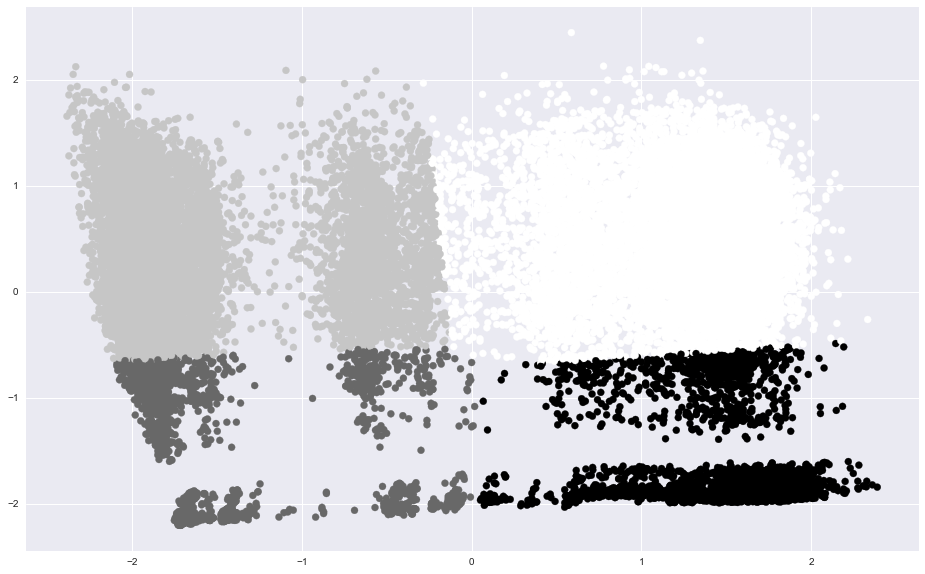

In [92]:
plt.pyplot.scatter(df_pca[:,0], df_pca[:,1], c=clustered_labels_km)
pylab.show()